# Ramp Up Model Size

- I want to measure accuracy on all point with these models, and get things a bit streamlined
- Minibatches and training on all examples across the board too

In [1]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import torch.optim as optim
import cv2
from matplotlib.gridspec import GridSpec
from tqdm import tqdm
import os
from torch.utils.data import DataLoader, TensorDataset

In [2]:
def denorm(p, size=960):
    result = np.zeros_like(p)
    result[..., 0] = (p[..., 0] + 1) * (size / 2)
    result[..., 1] = size - ((p[..., 1] + 1) * (size / 2))
    return result

In [3]:
map=cv2.imread('Baarle-Nassau_-_Baarle-Hertog-en no legend.png')[:,:,(2,1,0)]

belgium_color=np.array([251,234,81])
netherlands_color=np.array([255, 255, 228])

netherlands_region=((map-netherlands_color)**2).sum(-1)<50
belgium_region=((map-belgium_color)**2).sum(-1)<10000


b_coords=np.array(np.where(belgium_region)).T.astype('float')
n_coords=np.array(np.where(netherlands_region)).T.astype('float')

#flip and normalize
belgium_coords_all=np.zeros_like(b_coords)
netherlands_coords_all=np.zeros_like(n_coords)

belgium_coords_all[:,0]=b_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
belgium_coords_all[:,1]=(960-b_coords[:,0])/(960/2)-1
netherlands_coords_all[:,0]=n_coords[:,1]/(960/2)-1 #Scale to -1 to 1 for now
netherlands_coords_all[:,1]=(960-n_coords[:,0])/(960/2)-1

## Hmm to balance to classes or do more area proportional? Not sure yet. 
np.random.seed(55)
num_points_to_sample=10000 #10000
belgium_coords_sample=belgium_coords_all[np.random.choice(len(belgium_coords_all), num_points_to_sample), :]
netherlands_coords_sample=netherlands_coords_all[np.random.choice(len(netherlands_coords_all), num_points_to_sample), :]
X_sample=np.vstack((netherlands_coords_sample, belgium_coords_sample))
y_sample=np.concatenate((np.zeros(len(belgium_coords_sample)), np.ones(len(netherlands_coords_sample)))).astype('int')
X_sample = torch.FloatTensor(X_sample)
y_sample = torch.tensor(y_sample)

#Skip sampling train on all. 
belgium_coords=belgium_coords_all
netherlands_coords=netherlands_coords_all

X=np.vstack((netherlands_coords, belgium_coords))
y=np.concatenate((np.zeros(len(netherlands_coords)), np.ones(len(belgium_coords)))).astype('int')

X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

In [4]:
X_tensor.shape, y_tensor.shape, X_sample.shape, y_sample.shape

(torch.Size([855665, 2]),
 torch.Size([855665]),
 torch.Size([20000, 2]),
 torch.Size([20000]))

In [5]:
class BaarleNet(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNet, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.ReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [6]:
class BaarleNetLeaky(nn.Module):
    def __init__(self, hidden_layers=[64]):
        super(BaarleNetLeaky, self).__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.LeakyReLU()]
        for i in range(len(hidden_layers)-1):
            layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
            layers.append(nn.LeakyReLU())
        layers.append(nn.Linear(hidden_layers[-1], 2))
        self.layers=layers
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
def viz_descision_boundary(model, res=256):
    plt.clf()
    fig=plt.figure(0,(6,6))
    ax=fig.add_subplot(111)
    
    probe=np.zeros((res,res,2))
    for j, xx in enumerate(np.linspace(-1, 1, res)):
        for k, yy in enumerate(np.linspace(-1, 1, res)):
            probe[j, k]=[yy,xx]
    probe=probe.reshape(res**2, -1)
    probe_logits=model(torch.tensor(probe).float())
    probe_logits=probe_logits.detach().numpy().reshape(res,res,2)
    probe_softmax = torch.nn.Softmax(dim=1)(torch.tensor(probe_logits.reshape(-1, 2)))
    
    ax.imshow(map.mean(2), cmap='gray')
    ax.imshow(np.flipud(np.argmax(probe_logits,2)), 
               extent=[0, 960, 960, 0],  # This maps to image coordinates
               alpha=0.7,
               cmap='viridis')


In [8]:
num_epochs=200
random_seed=25

# 8

In [9]:
device='cpu'
batch_size = 10000

for random_seed in range(32):
    print(random_seed)

    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([8]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    num_epochs = 2
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X.to(device))
            loss = criterion(outputs, batch_y.to(device))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / num_batches

    # Calculate accuracy on full dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

0
Epoch [2/2], Loss: 0.2572, Accuracy: 0.7676
1
Epoch [2/2], Loss: 0.2651, Accuracy: 0.7756
2
Epoch [2/2], Loss: 0.2688, Accuracy: 0.7617
3
Epoch [2/2], Loss: 0.2310, Accuracy: 0.8234
4
Epoch [2/2], Loss: 0.2551, Accuracy: 0.7761
5
Epoch [2/2], Loss: 0.2858, Accuracy: 0.7383
6
Epoch [2/2], Loss: 0.2920, Accuracy: 0.7796
7
Epoch [2/2], Loss: 0.2726, Accuracy: 0.7946
8
Epoch [2/2], Loss: 0.2482, Accuracy: 0.7938
9
Epoch [2/2], Loss: 0.2440, Accuracy: 0.8110
10
Epoch [2/2], Loss: 0.2858, Accuracy: 0.7742
11
Epoch [2/2], Loss: 0.2562, Accuracy: 0.7833
12
Epoch [2/2], Loss: 0.2337, Accuracy: 0.8266
13
Epoch [2/2], Loss: 0.2489, Accuracy: 0.8410
14
Epoch [2/2], Loss: 0.2471, Accuracy: 0.7906
15
Epoch [2/2], Loss: 0.2651, Accuracy: 0.7766
16
Epoch [2/2], Loss: 0.2598, Accuracy: 0.7914
17
Epoch [2/2], Loss: 0.2795, Accuracy: 0.7447
18
Epoch [2/2], Loss: 0.2536, Accuracy: 0.7833
19
Epoch [2/2], Loss: 0.2589, Accuracy: 0.7839
20
Epoch [2/2], Loss: 0.2511, Accuracy: 0.7872
21
Epoch [2/2], Loss: 0

In [13]:
device='cpu'
batch_size = 10000
random_seed=26 #23

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([8]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)
num_epochs = 5

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 50) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/50], Loss: 0.2986, Accuracy: 0.8173
Epoch [2/50], Loss: 0.2177, Accuracy: 0.8477
Epoch [3/50], Loss: 0.2065, Accuracy: 0.8507
Epoch [4/50], Loss: 0.2053, Accuracy: 0.8570
Epoch [5/50], Loss: 0.2046, Accuracy: 0.8388
Epoch [6/50], Loss: 0.2044, Accuracy: 0.8427
Epoch [7/50], Loss: 0.2039, Accuracy: 0.8502
Epoch [8/50], Loss: 0.2043, Accuracy: 0.8567
Epoch [9/50], Loss: 0.2046, Accuracy: 0.8485
Epoch [10/50], Loss: 0.2042, Accuracy: 0.8498


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ade0dec1e10>>
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/sora/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


Epoch [11/50], Loss: 0.2046, Accuracy: 0.8461


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ade0dec1e10>>
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/sora/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

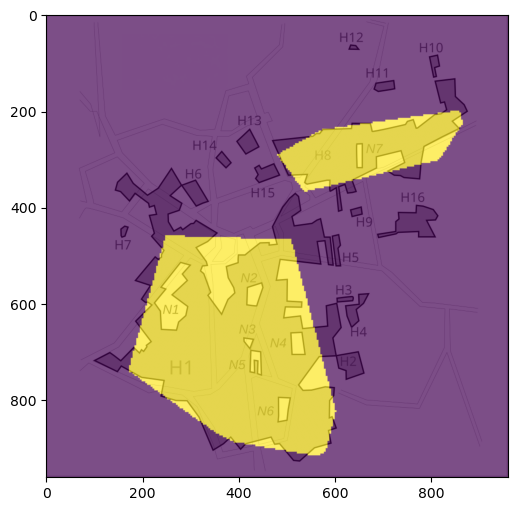

In [14]:
viz_descision_boundary(model)

In [15]:
torch.save(model.state_dict(), '../models/8_2.pth')

# 16

In [10]:
device='cpu'
batch_size = 10000

for random_seed in range(32):
    print(random_seed)

    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([16]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    num_epochs = 4
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X.to(device))
            loss = criterion(outputs, batch_y.to(device))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / num_batches

    # Calculate accuracy on full dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

0
Epoch [4/4], Loss: 0.2473, Accuracy: 0.7862
1
Epoch [4/4], Loss: 0.2000, Accuracy: 0.8413
2
Epoch [4/4], Loss: 0.1972, Accuracy: 0.8270
3
Epoch [4/4], Loss: 0.2003, Accuracy: 0.8469
4
Epoch [4/4], Loss: 0.2050, Accuracy: 0.8327
5
Epoch [4/4], Loss: 0.2051, Accuracy: 0.8465
6
Epoch [4/4], Loss: 0.2037, Accuracy: 0.8448
7
Epoch [4/4], Loss: 0.1970, Accuracy: 0.8326
8
Epoch [4/4], Loss: 0.1992, Accuracy: 0.8599
9
Epoch [4/4], Loss: 0.2095, Accuracy: 0.8454
10
Epoch [4/4], Loss: 0.2031, Accuracy: 0.8592
11
Epoch [4/4], Loss: 0.2399, Accuracy: 0.7873
12
Epoch [4/4], Loss: 0.2004, Accuracy: 0.8406
13
Epoch [4/4], Loss: 0.1988, Accuracy: 0.8527
14
Epoch [4/4], Loss: 0.2156, Accuracy: 0.8490
15
Epoch [4/4], Loss: 0.2052, Accuracy: 0.8407
16
Epoch [4/4], Loss: 0.2066, Accuracy: 0.8498
17
Epoch [4/4], Loss: 0.2008, Accuracy: 0.8295
18
Epoch [4/4], Loss: 0.2402, Accuracy: 0.7995
19
Epoch [4/4], Loss: 0.2032, Accuracy: 0.8609
20
Epoch [4/4], Loss: 0.1953, Accuracy: 0.8395
21
Epoch [4/4], Loss: 0

In [16]:
device='cpu'
batch_size = 10000
random_seed=26

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/100], Loss: 0.3273, Accuracy: 0.7667
Epoch [2/100], Loss: 0.2489, Accuracy: 0.7890
Epoch [3/100], Loss: 0.2213, Accuracy: 0.8405
Epoch [4/100], Loss: 0.2066, Accuracy: 0.8593
Epoch [5/100], Loss: 0.2039, Accuracy: 0.8542
Epoch [6/100], Loss: 0.2027, Accuracy: 0.8605
Epoch [7/100], Loss: 0.2023, Accuracy: 0.8581
Epoch [8/100], Loss: 0.2003, Accuracy: 0.8456
Epoch [9/100], Loss: 0.1986, Accuracy: 0.8495
Epoch [10/100], Loss: 0.1982, Accuracy: 0.8675
Epoch [11/100], Loss: 0.1976, Accuracy: 0.8541
Epoch [12/100], Loss: 0.1966, Accuracy: 0.8397
Epoch [13/100], Loss: 0.1958, Accuracy: 0.8597
Epoch [14/100], Loss: 0.1956, Accuracy: 0.8432
Epoch [15/100], Loss: 0.1954, Accuracy: 0.8491
Epoch [16/100], Loss: 0.1949, Accuracy: 0.8615
Epoch [17/100], Loss: 0.1950, Accuracy: 0.8606
Epoch [18/100], Loss: 0.1951, Accuracy: 0.8467
Epoch [19/100], Loss: 0.1948, Accuracy: 0.8475
Epoch [20/100], Loss: 0.1942, Accuracy: 0.8602
Epoch [21/100], Loss: 0.1944, Accuracy: 0.8496
Epoch [22/100], Loss: 

<Figure size 640x480 with 0 Axes>

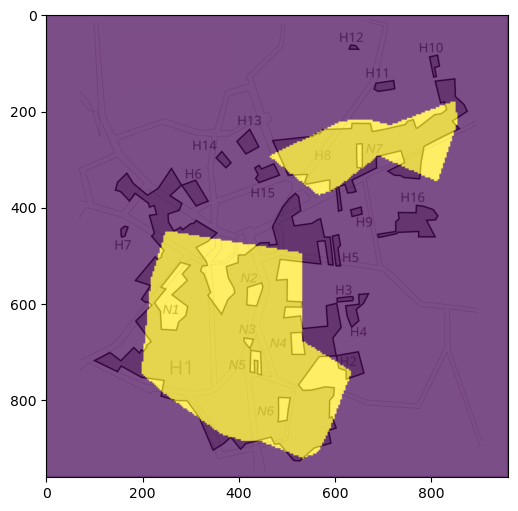

In [17]:
viz_descision_boundary(model)

In [18]:
torch.save(model.state_dict(), '../models/16_1.pth')

# 32

In [11]:
device='cpu'
batch_size = 10000

for random_seed in range(32):
    print(random_seed)

    torch.manual_seed(random_seed)  
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.tensor(y)
    
    # Create dataset and dataloader for minibatching
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Initialize model and optimizer
    model = BaarleNet([32]).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    num_epochs = 6
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        num_batches = 0
        
        for batch_X, batch_y in dataloader:
            # Forward pass
            outputs = model(batch_X.to(device))
            loss = criterion(outputs, batch_y.to(device))
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            num_batches += 1
        
        # Calculate average loss for the epoch
        avg_loss = epoch_loss / num_batches

    # Calculate accuracy on full dataset
    with torch.no_grad():
        outputs_batch = model(X_sample.to(device))
        accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

0
Epoch [6/6], Loss: 0.1862, Accuracy: 0.8649
1
Epoch [6/6], Loss: 0.1876, Accuracy: 0.8741
2
Epoch [6/6], Loss: 0.1971, Accuracy: 0.8557
3
Epoch [6/6], Loss: 0.1864, Accuracy: 0.8659
4
Epoch [6/6], Loss: 0.1801, Accuracy: 0.8471
5
Epoch [6/6], Loss: 0.1821, Accuracy: 0.8519
6
Epoch [6/6], Loss: 0.1851, Accuracy: 0.8724
7


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7ade0dec1e10>>
Traceback (most recent call last):
  File "/home/stephen/anaconda3/envs/sora/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

In [19]:
device='cpu'
batch_size = 10000
random_seed=1

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([32]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.05)
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/100], Loss: 0.3100, Accuracy: 0.7909
Epoch [2/100], Loss: 0.2230, Accuracy: 0.8460
Epoch [3/100], Loss: 0.2051, Accuracy: 0.8675
Epoch [4/100], Loss: 0.1947, Accuracy: 0.8552
Epoch [5/100], Loss: 0.1893, Accuracy: 0.8599
Epoch [6/100], Loss: 0.1880, Accuracy: 0.8714
Epoch [7/100], Loss: 0.1860, Accuracy: 0.8586
Epoch [8/100], Loss: 0.1836, Accuracy: 0.8544
Epoch [9/100], Loss: 0.1819, Accuracy: 0.8629


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

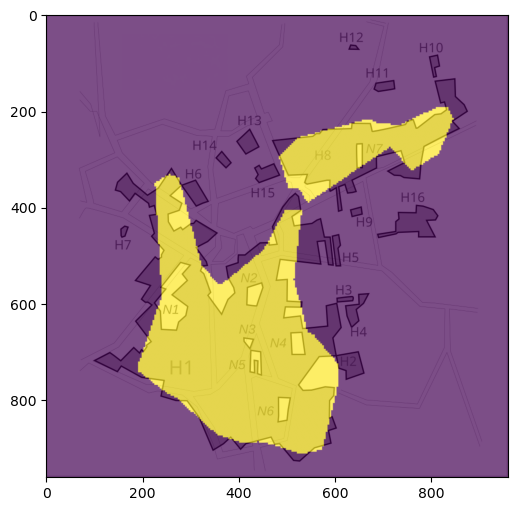

In [20]:
viz_descision_boundary(model)

In [21]:
torch.save(model.state_dict(), '../models/32_1.pth')

# 128

## 256

## 512

In [ ]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNetLeaky([512]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 3000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
viz_descision_boundary(model)

In [ ]:
torch.save(model.state_dict(), '../models/leaky_512_1.pth')

## [8, 8]

In [8]:
device='cpu'
batch_size = 512

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([8, 8]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

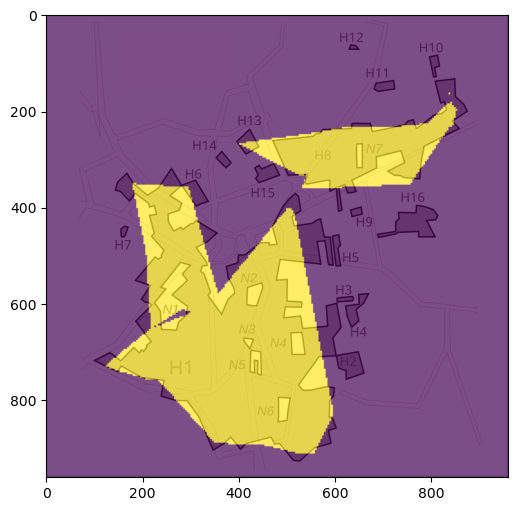

In [9]:
viz_descision_boundary(model)

In [10]:
torch.save(model.state_dict(), '../models/8_8_1.pth')

# [16, 16]

In [ ]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([16, 16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/200], Loss: 0.1843, Accuracy: 0.8804
Epoch [20/200], Loss: 0.1728, Accuracy: 0.8868
Epoch [30/200], Loss: 0.1564, Accuracy: 0.8791
Epoch [40/200], Loss: 0.1534, Accuracy: 0.8860


In [ ]:
viz_descision_boundary(model)

In [ ]:
torch.save(model.state_dict(), '../models/16_16_1.pth')

## [16, 16, 16]

In [ ]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([16, 16, 16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
viz_descision_boundary(model)

In [ ]:
torch.save(model.state_dict(), '../models/16_16_16_1.pth')

## [64]

In [ ]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
# num_epochs = 20

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
viz_descision_boundary(model)

In [ ]:
torch.save(model.state_dict(), '../models/64_1.pth')

## [16 16 16]

In [ ]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([16, 16, 16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 3000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

In [ ]:
viz_descision_boundary(model)

In [ ]:
torch.save(model.state_dict(), '../models/16_16_16_1.pth')

## [ 32 32 32]

In [29]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([32, 32, 32]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 3000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [150/3000], Loss: 0.0782, Accuracy: 0.9466
Epoch [300/3000], Loss: 0.0690, Accuracy: 0.9614
Epoch [450/3000], Loss: 0.0626, Accuracy: 0.9709
Epoch [600/3000], Loss: 0.0625, Accuracy: 0.9708
Epoch [750/3000], Loss: 0.0503, Accuracy: 0.9687
Epoch [900/3000], Loss: 0.0603, Accuracy: 0.9778
Epoch [1050/3000], Loss: 0.0414, Accuracy: 0.9739
Epoch [1200/3000], Loss: 0.0398, Accuracy: 0.9792
Epoch [1350/3000], Loss: 0.0430, Accuracy: 0.9587
Epoch [1500/3000], Loss: 0.0393, Accuracy: 0.9697
Epoch [1650/3000], Loss: 0.0374, Accuracy: 0.9680
Epoch [1800/3000], Loss: 0.0349, Accuracy: 0.9724
Epoch [1950/3000], Loss: 0.0392, Accuracy: 0.9776
Epoch [2100/3000], Loss: 0.0356, Accuracy: 0.9841
Epoch [2250/3000], Loss: 0.0341, Accuracy: 0.9760
Epoch [2400/3000], Loss: 0.0369, Accuracy: 0.9668
Epoch [2550/3000], Loss: 0.0340, Accuracy: 0.9842
Epoch [2700/3000], Loss: 0.0318, Accuracy: 0.9805
Epoch [2850/3000], Loss: 0.0335, Accuracy: 0.9548
Epoch [3000/3000], Loss: 0.0335, Accuracy: 0.9786


<Figure size 640x480 with 0 Axes>

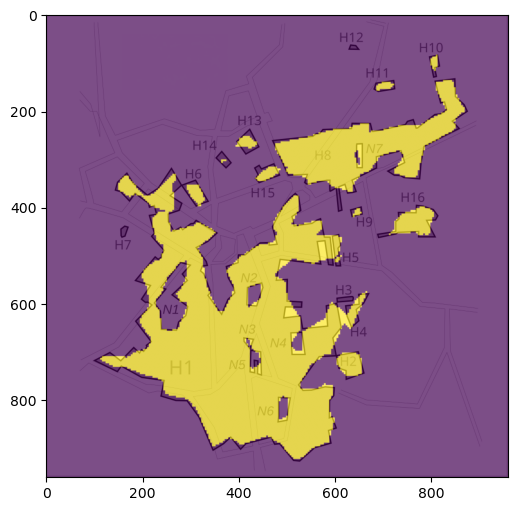

In [30]:
viz_descision_boundary(model)

In [31]:
torch.save(model.state_dict(), '../models/32_32_32_1.pth')

## [64, 64, 64]

In [11]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([64, 64, 64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 1000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [50/1000], Loss: 0.0480, Accuracy: 0.9796
Epoch [100/1000], Loss: 0.0409, Accuracy: 0.9826
Epoch [150/1000], Loss: 0.0302, Accuracy: 0.9744
Epoch [200/1000], Loss: 0.0310, Accuracy: 0.9869
Epoch [250/1000], Loss: 0.0255, Accuracy: 0.9885
Epoch [300/1000], Loss: 0.0224, Accuracy: 0.9823
Epoch [350/1000], Loss: 0.0216, Accuracy: 0.9900
Epoch [400/1000], Loss: 0.0186, Accuracy: 0.9839
Epoch [450/1000], Loss: 0.0173, Accuracy: 0.9912
Epoch [500/1000], Loss: 0.0188, Accuracy: 0.9903
Epoch [550/1000], Loss: 0.0185, Accuracy: 0.9812
Epoch [600/1000], Loss: 0.0190, Accuracy: 0.9753
Epoch [650/1000], Loss: 0.0148, Accuracy: 0.9907
Epoch [700/1000], Loss: 0.0188, Accuracy: 0.9905
Epoch [750/1000], Loss: 0.0159, Accuracy: 0.9915
Epoch [800/1000], Loss: 0.0159, Accuracy: 0.9874
Epoch [850/1000], Loss: 0.0144, Accuracy: 0.9908
Epoch [900/1000], Loss: 0.0130, Accuracy: 0.9902
Epoch [950/1000], Loss: 0.0206, Accuracy: 0.9864
Epoch [1000/1000], Loss: 0.0152, Accuracy: 0.9877


<Figure size 640x480 with 0 Axes>

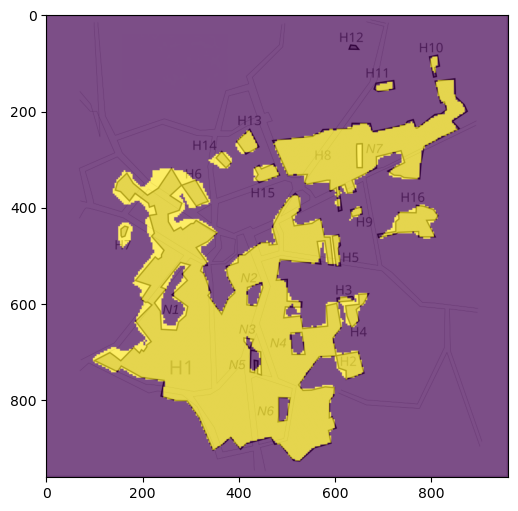

In [12]:
viz_descision_boundary(model)

In [14]:
torch.save(model.state_dict(), '../models/64_64_64_1.pth')

## 4 4 4 4 

In [11]:
# class BaarleNetLeaky(nn.Module):
#     def __init__(self, hidden_layers=[64]):
#         super(BaarleNetLeaky, self).__init__()
#         layers = [nn.Linear(2, hidden_layers[0]), nn.LeakyReLU()]
#         for i in range(len(hidden_layers)-1):
#             layers.append(nn.Linear(hidden_layers[i], hidden_layers[i+1]))
#             layers.append(nn.LeakyReLU())
#         layers.append(nn.Linear(hidden_layers[-1], 2))
#         self.layers=layers
#         self.model = nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)

In [12]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNetLeaky([4, 4, 4, 4]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 1000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [10/1000], Loss: 0.2035, Accuracy: 0.8347
Epoch [20/1000], Loss: 0.1986, Accuracy: 0.8345
Epoch [30/1000], Loss: 0.1872, Accuracy: 0.8518
Epoch [40/1000], Loss: 0.1852, Accuracy: 0.8501
Epoch [50/1000], Loss: 0.1844, Accuracy: 0.8538
Epoch [60/1000], Loss: 0.1820, Accuracy: 0.8560
Epoch [70/1000], Loss: 0.1766, Accuracy: 0.8649
Epoch [80/1000], Loss: 0.1741, Accuracy: 0.8521
Epoch [90/1000], Loss: 0.1732, Accuracy: 0.8563
Epoch [100/1000], Loss: 0.1726, Accuracy: 0.8568
Epoch [110/1000], Loss: 0.1719, Accuracy: 0.8675
Epoch [120/1000], Loss: 0.1712, Accuracy: 0.8634
Epoch [130/1000], Loss: 0.1681, Accuracy: 0.8640
Epoch [140/1000], Loss: 0.1677, Accuracy: 0.8713
Epoch [150/1000], Loss: 0.1669, Accuracy: 0.8639
Epoch [160/1000], Loss: 0.1670, Accuracy: 0.8721
Epoch [170/1000], Loss: 0.1665, Accuracy: 0.8668
Epoch [180/1000], Loss: 0.1657, Accuracy: 0.8659
Epoch [190/1000], Loss: 0.1664, Accuracy: 0.8719
Epoch [200/1000], Loss: 0.1662, Accuracy: 0.8685
Epoch [210/1000], Loss: 0.165

<Figure size 640x480 with 0 Axes>

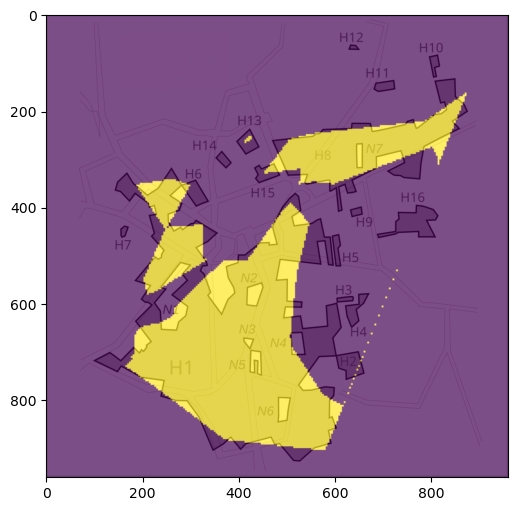

In [13]:
viz_descision_boundary(model)

In [14]:
torch.save(model.state_dict(), '../models/leaky_4_4_4_4_1.pth')

## Leaky 16 16 16 16 

In [19]:
device='cpu'
batch_size = 10000
random_seed=52

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNetLeaky([16, 16, 16, 16]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)
num_epochs = 3500

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [35/3500], Loss: 0.0893, Accuracy: 0.9322
Epoch [70/3500], Loss: 0.0783, Accuracy: 0.9460
Epoch [105/3500], Loss: 0.0716, Accuracy: 0.9580
Epoch [140/3500], Loss: 0.0679, Accuracy: 0.9606
Epoch [175/3500], Loss: 0.0636, Accuracy: 0.9407
Epoch [210/3500], Loss: 0.0631, Accuracy: 0.9608
Epoch [245/3500], Loss: 0.0589, Accuracy: 0.9666
Epoch [280/3500], Loss: 0.0553, Accuracy: 0.9675
Epoch [315/3500], Loss: 0.0537, Accuracy: 0.9700
Epoch [350/3500], Loss: 0.0554, Accuracy: 0.9739
Epoch [385/3500], Loss: 0.0511, Accuracy: 0.9636
Epoch [420/3500], Loss: 0.0505, Accuracy: 0.9720
Epoch [455/3500], Loss: 0.0484, Accuracy: 0.9643
Epoch [490/3500], Loss: 0.0507, Accuracy: 0.9663
Epoch [525/3500], Loss: 0.0488, Accuracy: 0.9730
Epoch [560/3500], Loss: 0.0479, Accuracy: 0.9716
Epoch [595/3500], Loss: 0.0463, Accuracy: 0.9697
Epoch [630/3500], Loss: 0.0442, Accuracy: 0.9758
Epoch [665/3500], Loss: 0.0456, Accuracy: 0.9782
Epoch [700/3500], Loss: 0.0434, Accuracy: 0.9708
Epoch [735/3500], Loss

<Figure size 640x480 with 0 Axes>

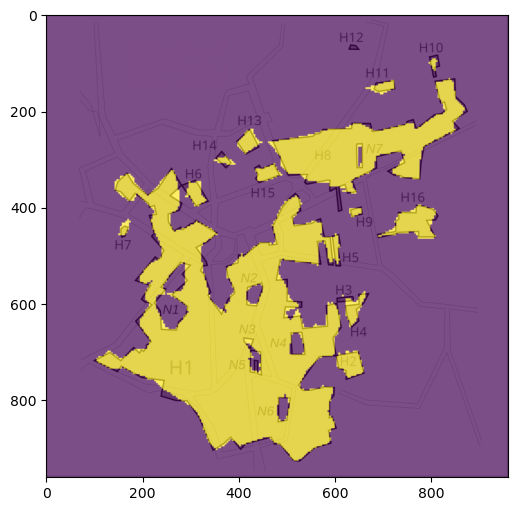

In [20]:
viz_descision_boundary(model)

In [21]:
torch.save(model.state_dict(), '../models/leaky_16_16_16_16_2.pth')

## Leaky 20 20 20 20 

In [22]:
device='cpu'
batch_size = 10000
random_seed=52

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNetLeaky([20, 20, 20, 20]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.004)
num_epochs = 3500

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 100) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [35/3500], Loss: 0.0752, Accuracy: 0.9500
Epoch [70/3500], Loss: 0.0581, Accuracy: 0.9486
Epoch [105/3500], Loss: 0.0477, Accuracy: 0.9625
Epoch [140/3500], Loss: 0.0452, Accuracy: 0.9783
Epoch [175/3500], Loss: 0.0445, Accuracy: 0.9791
Epoch [210/3500], Loss: 0.0396, Accuracy: 0.9591
Epoch [245/3500], Loss: 0.0348, Accuracy: 0.9805
Epoch [280/3500], Loss: 0.0351, Accuracy: 0.9779
Epoch [315/3500], Loss: 0.0341, Accuracy: 0.9737
Epoch [350/3500], Loss: 0.0351, Accuracy: 0.9778
Epoch [385/3500], Loss: 0.0374, Accuracy: 0.9803
Epoch [420/3500], Loss: 0.0326, Accuracy: 0.9806
Epoch [455/3500], Loss: 0.0327, Accuracy: 0.9798
Epoch [490/3500], Loss: 0.0317, Accuracy: 0.9765
Epoch [525/3500], Loss: 0.0294, Accuracy: 0.9834
Epoch [560/3500], Loss: 0.0314, Accuracy: 0.9610
Epoch [595/3500], Loss: 0.0289, Accuracy: 0.9829
Epoch [630/3500], Loss: 0.0286, Accuracy: 0.9777
Epoch [665/3500], Loss: 0.0298, Accuracy: 0.9860
Epoch [700/3500], Loss: 0.0276, Accuracy: 0.9840
Epoch [735/3500], Loss

<Figure size 640x480 with 0 Axes>

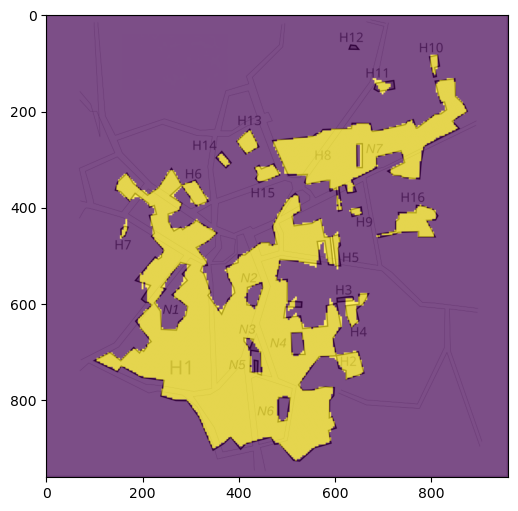

In [23]:
viz_descision_boundary(model)

In [24]:
torch.save(model.state_dict(), '../models/leaky_20_20_20_20_1.pth')

## 24 24 24 24

In [26]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([24, 24, 24, 24]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 3000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [150/3000], Loss: 0.0470, Accuracy: 0.9664
Epoch [300/3000], Loss: 0.0371, Accuracy: 0.9635
Epoch [450/3000], Loss: 0.0279, Accuracy: 0.9826
Epoch [600/3000], Loss: 0.0314, Accuracy: 0.9778
Epoch [750/3000], Loss: 0.0235, Accuracy: 0.9819
Epoch [900/3000], Loss: 0.0228, Accuracy: 0.9886
Epoch [1050/3000], Loss: 0.0224, Accuracy: 0.9829
Epoch [1200/3000], Loss: 0.0209, Accuracy: 0.9840
Epoch [1350/3000], Loss: 0.0205, Accuracy: 0.9909
Epoch [1500/3000], Loss: 0.0186, Accuracy: 0.9899
Epoch [1650/3000], Loss: 0.0173, Accuracy: 0.9793
Epoch [1800/3000], Loss: 0.0188, Accuracy: 0.9893
Epoch [1950/3000], Loss: 0.0183, Accuracy: 0.9904
Epoch [2100/3000], Loss: 0.0148, Accuracy: 0.9887
Epoch [2250/3000], Loss: 0.0186, Accuracy: 0.9870
Epoch [2400/3000], Loss: 0.0157, Accuracy: 0.9914
Epoch [2550/3000], Loss: 0.0159, Accuracy: 0.9906
Epoch [2700/3000], Loss: 0.0142, Accuracy: 0.9929
Epoch [2850/3000], Loss: 0.0128, Accuracy: 0.9929
Epoch [3000/3000], Loss: 0.0147, Accuracy: 0.9889


<Figure size 640x480 with 0 Axes>

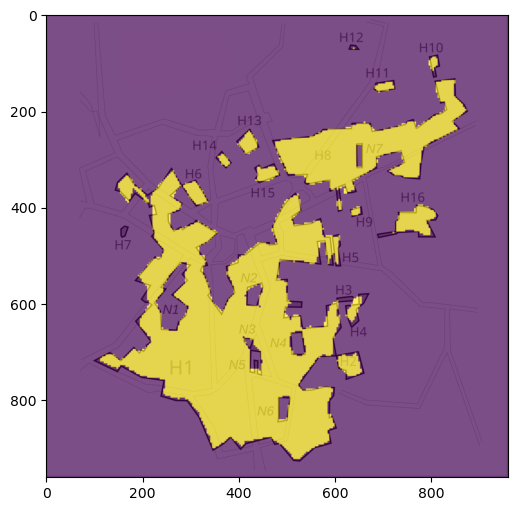

In [27]:
viz_descision_boundary(model)

In [28]:
torch.save(model.state_dict(), '../models/24_24_24_24_1.pth')

## 32 32 32 32

In [22]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([32, 32, 32, 32]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 3000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [150/3000], Loss: 0.0454, Accuracy: 0.9714
Epoch [300/3000], Loss: 0.0303, Accuracy: 0.9801
Epoch [450/3000], Loss: 0.0252, Accuracy: 0.9866
Epoch [600/3000], Loss: 0.0265, Accuracy: 0.9862
Epoch [750/3000], Loss: 0.0246, Accuracy: 0.9831
Epoch [900/3000], Loss: 0.0163, Accuracy: 0.9913
Epoch [1050/3000], Loss: 0.0145, Accuracy: 0.9876
Epoch [1200/3000], Loss: 0.0147, Accuracy: 0.9904
Epoch [1350/3000], Loss: 0.0138, Accuracy: 0.9843
Epoch [1500/3000], Loss: 0.0142, Accuracy: 0.9899
Epoch [1650/3000], Loss: 0.0132, Accuracy: 0.9921
Epoch [1800/3000], Loss: 0.0128, Accuracy: 0.9921
Epoch [1950/3000], Loss: 0.0125, Accuracy: 0.9943
Epoch [2100/3000], Loss: 0.0111, Accuracy: 0.9918
Epoch [2250/3000], Loss: 0.0097, Accuracy: 0.9949
Epoch [2400/3000], Loss: 0.0119, Accuracy: 0.9933
Epoch [2550/3000], Loss: 0.0111, Accuracy: 0.9915
Epoch [2700/3000], Loss: 0.0142, Accuracy: 0.9906
Epoch [2850/3000], Loss: 0.0152, Accuracy: 0.9855
Epoch [3000/3000], Loss: 0.0079, Accuracy: 0.9950


<Figure size 640x480 with 0 Axes>

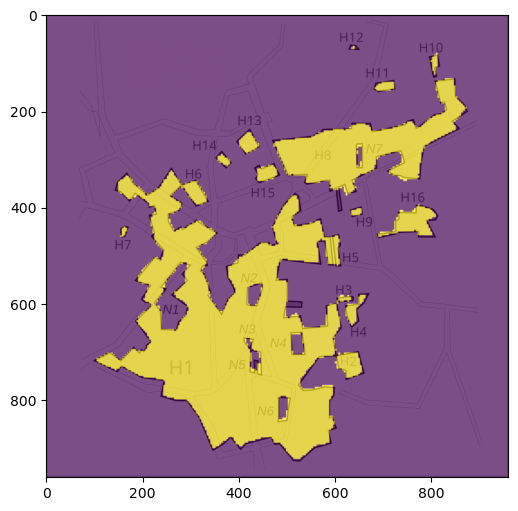

In [23]:
viz_descision_boundary(model)

In [24]:
torch.save(model.state_dict(), '../models/32_32_32_32_1.pth')

## 64 64 64 64

In [15]:
device='cpu'
batch_size = 10000

torch.manual_seed(random_seed)  
X_tensor = torch.FloatTensor(X)
y_tensor = torch.tensor(y)

# Create dataset and dataloader for minibatching
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize model and optimizer
model = BaarleNet([64, 64, 64, 64]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
num_epochs = 1000

for epoch in range(num_epochs):
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_X, batch_y in dataloader:
        # Forward pass
        outputs = model(batch_X.to(device))
        loss = criterion(outputs, batch_y.to(device))
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / num_batches
    
    if (epoch + 1) % (num_epochs // 20) == 0:
        # Calculate accuracy on full dataset
        with torch.no_grad():
            outputs_batch = model(X_sample.to(device))
            accuracy = (torch.argmax(outputs_batch, dim=1) == y_sample.to(device)).sum().item() / len(y_sample)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [50/1000], Loss: 0.0300, Accuracy: 0.9790
Epoch [100/1000], Loss: 0.0217, Accuracy: 0.9835
Epoch [150/1000], Loss: 0.0166, Accuracy: 0.9926
Epoch [200/1000], Loss: 0.0166, Accuracy: 0.9899
Epoch [250/1000], Loss: 0.0101, Accuracy: 0.9959
Epoch [300/1000], Loss: 0.0105, Accuracy: 0.9952
Epoch [350/1000], Loss: 0.0101, Accuracy: 0.9955
Epoch [400/1000], Loss: 0.0066, Accuracy: 0.9952
Epoch [450/1000], Loss: 0.0086, Accuracy: 0.9909
Epoch [500/1000], Loss: 0.0049, Accuracy: 0.9974
Epoch [550/1000], Loss: 0.0053, Accuracy: 0.9970
Epoch [600/1000], Loss: 0.0070, Accuracy: 0.9959
Epoch [650/1000], Loss: 0.0038, Accuracy: 0.9961
Epoch [700/1000], Loss: 0.0029, Accuracy: 0.9990
Epoch [750/1000], Loss: 0.0087, Accuracy: 0.9970
Epoch [800/1000], Loss: 0.0031, Accuracy: 0.9986
Epoch [850/1000], Loss: 0.0016, Accuracy: 0.9999
Epoch [900/1000], Loss: 0.0026, Accuracy: 0.9979
Epoch [950/1000], Loss: 0.0064, Accuracy: 0.9934
Epoch [1000/1000], Loss: 0.0034, Accuracy: 0.9983


<Figure size 640x480 with 0 Axes>

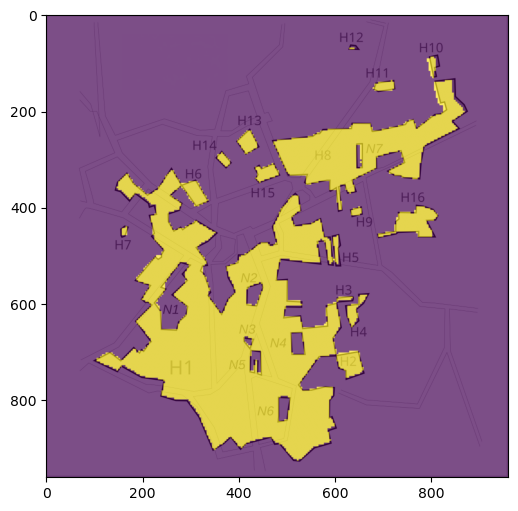

In [16]:
viz_descision_boundary(model)

In [18]:
torch.save(model.state_dict(), '../models/64_64_64_64_1.pth')